In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15819, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 15819 (delta 31), reused 43 (delta 17), pack-reused 15743 (from 1)
Receiving objects: 100% (15819/15819), 6.39 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (11523/11523), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your e

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
#print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121


In [3]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import json
from detectron2.structures import BoxMode

def get_data_dicts(dir, classes):
    dataset_dicts = []
    for subdir1 in ["train", "test"]: #Fixed loop to only get data under /content/drive/MyDrive/data/train or /content/drive/MyDrive/data/test
        subdir1_path = os.path.join(dir, "") # remove extra subdir level
        for subdir2 in ["L-vorm", "U-vorm", "Parallel"]:
            subdir2_path = os.path.join(subdir1_path, subdir2)
            for filename in [file for file in os.listdir(subdir2_path) if file.endswith('.json')]:
                json_file = os.path.join(subdir2_path, filename)
                with open(json_file) as f:
                    img_anns = json.load(f)

                record = {}
                filename = os.path.join(subdir2_path, img_anns["imagePath"])

                record["file_name"] = filename
                record["height"] = img_anns["imageHeight"]
                record["width"] = img_anns["imageWidth"]
                record["image_id"] = filename # you might need a better unique identifier

                objs = []
                for shape in img_anns["shapes"]:
                    px = [a[0] for a in shape['points']]
                    py = [a[1] for a in shape['points']]
                    poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                    poly = [p for x in poly for p in x]

                    category_id = classes.index(shape['label'])  # Get category id

                    obj = {
                        "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "segmentation": [poly],
                        "category_id": category_id, #Fixed category ID index
                        "iscrowd": 0
                    }
                    objs.append(obj)
                record["annotations"] = objs
                dataset_dicts.append(record)
    return dataset_dicts

In [6]:

classes = ['stove',"sink","storage","counter"]

data_path = "/content/drive/MyDrive/data/" # Added a trailing slash

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d,
        lambda d=d: get_data_dicts(data_path + d, classes) # Now correctly joins data_path and d
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

In [7]:

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1600
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

In [9]:
import os

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[12/05 07:17:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 110MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [11]:

trainer.train()

[12/05 07:17:25 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/05 07:17:38 d2.utils.events]:  eta: 0:09:47  iter: 19  total_loss: 2.701  loss_cls: 1.633  loss_box_reg: 0.2098  loss_mask: 0.6937  loss_rpn_cls: 0.1385  loss_rpn_loc: 0.03539    time: 0.3716  last_time: 0.3214  data_time: 0.0407  last_data_time: 0.0184   lr: 4.9953e-06  max_mem: 1770M
[12/05 07:17:49 d2.utils.events]:  eta: 0:09:42  iter: 39  total_loss: 2.607  loss_cls: 1.495  loss_box_reg: 0.2122  loss_mask: 0.6933  loss_rpn_cls: 0.1692  loss_rpn_loc: 0.03439    time: 0.3890  last_time: 0.3895  data_time: 0.0371  last_data_time: 0.0065   lr: 9.9902e-06  max_mem: 1771M
[12/05 07:17:56 d2.utils.events]:  eta: 0:09:22  iter: 59  total_loss: 2.382  loss_cls: 1.223  loss_box_reg: 0.2355  loss_mask: 0.6928  loss_rpn_cls: 0.1498  loss_rpn_loc: 0.04019    time: 0.3767  last_time: 0.3329  data_time: 0.0060  last_data_time: 0.0053   lr: 1.4985e-05  max_mem: 1771M
[12/05 07:18:03 d2.utils.events]:  eta: 0:09:16  iter: 79  total_loss: 2.024  loss_cls: 0.8903  loss_box_reg: 0.2519  loss_mask

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.76
cfg.DATASETS.TEST = ("_test", )
predictor = DefaultPredictor(cfg)

[12/05 07:29:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [13]:

test_dataset_dicts = get_data_dicts(data_path+'test', classes)

In [14]:
import cv2

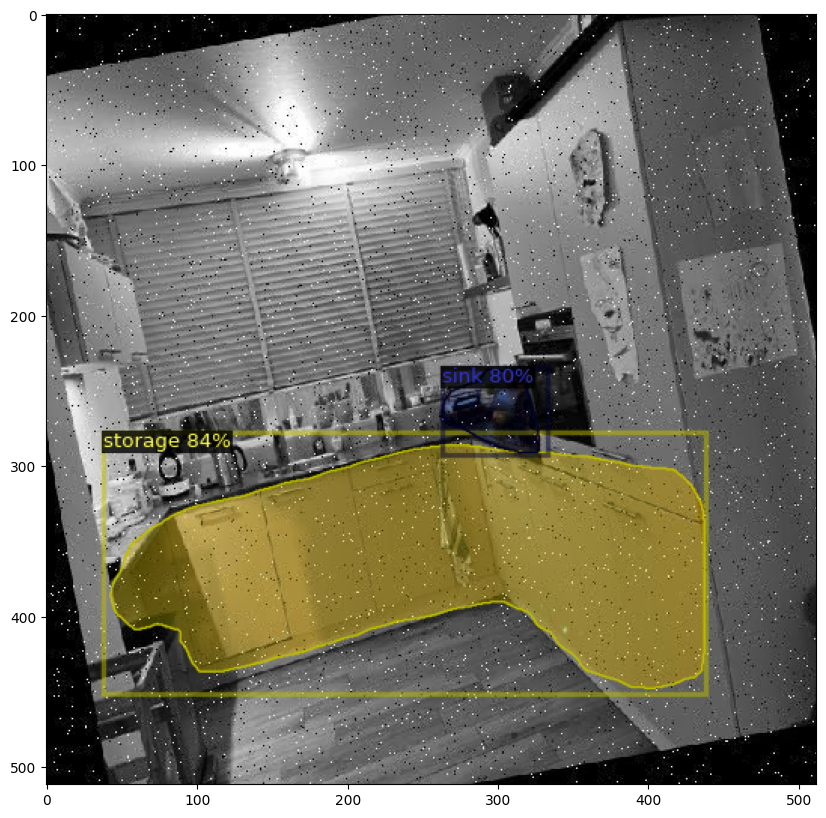

In [15]:


import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode, Visualizer

def predict_segmentation(image_path, predictor, metadata):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# Example usage (assuming predictor and metadata are defined as in your original code):
image_path = "/content/75aa3c80-85d9-11ed-b364-2b58f9ec1fc4_jpg.rf.bff41715073b8fc7c11a82df4dc1c4c8.jpg"
predict_segmentation(image_path, predictor, microcontroller_metadata)

In [16]:
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ToTensor, Resize

train_transforms = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(),
    RandomRotation(10),
    ToTensor()
])


In [17]:
import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet
model = models.resnet18(pretrained=True)

# Modify the final layer for 3 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes: Parallel, L-shaped, U-shaped


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


In [18]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root="/content/drive/MyDrive/data/train", transform=train_transforms)
test_dataset = ImageFolder(root='/content/drive/MyDrive/data/test', transform=Compose([Resize((224, 224)), ToTensor()]))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [19]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
class_weights = torch.tensor([1.0, 2.0, 1.5]).to(device)
criterion = CrossEntropyLoss(weight=class_weights)


for epoch in range(35):  # Number of epochs
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")


Epoch 1, Loss: 1.3192321807146072
Epoch 2, Loss: 0.6077253129333258
Epoch 3, Loss: 0.9186042007058859
Epoch 4, Loss: 0.6322293998673558
Epoch 5, Loss: 0.3954357081092894
Epoch 6, Loss: 0.6250310689210892
Epoch 7, Loss: 0.3661068044602871
Epoch 8, Loss: 0.6146966591477394
Epoch 9, Loss: 0.20879610255360603
Epoch 10, Loss: 0.14540864137234166
Epoch 11, Loss: 0.4777572564780712
Epoch 12, Loss: 0.750033400952816
Epoch 13, Loss: 0.9256846942007542
Epoch 14, Loss: 1.200191654264927
Epoch 15, Loss: 1.319856520742178
Epoch 16, Loss: 0.24359784461557865
Epoch 17, Loss: 0.3092028833925724
Epoch 18, Loss: 0.5162334330379963
Epoch 19, Loss: 0.4001791216433048
Epoch 20, Loss: 0.15575580997392535
Epoch 21, Loss: 0.4429435059428215
Epoch 22, Loss: 0.2687255069613457
Epoch 23, Loss: 0.8185243494808674
Epoch 24, Loss: 0.12366650346666574
Epoch 25, Loss: 0.36270355619490147
Epoch 26, Loss: 0.8415061142295599
Epoch 27, Loss: 0.33399632945656776
Epoch 28, Loss: 0.35943276435136795
Epoch 29, Loss: 0.113422

In [20]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")


Accuracy: 57.142857142857146%


In [21]:
torch.save(model.state_dict(), 'kitchen_layout_model.pth')


In [22]:
model.load_state_dict(torch.load('kitchen_layout_model.pth'))
model.eval()


<ipython-input-22-d0de1934cee5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('kitchen_layout_model.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
from PIL import Image

def predict_layout(image_path):
    img = Image.open(image_path).convert('RGB')
    img = Compose([Resize((224, 224)), ToTensor()])(img).unsqueeze(0).to(device)
    outputs = model(img)
    _, predicted = torch.max(outputs, 1)
    return train_dataset.classes[predicted.item()]

print(predict_layout('/content/75aa3c80-85d9-11ed-b364-2b58f9ec1fc4_jpg.rf.bff41715073b8fc7c11a82df4dc1c4c8.jpg'))


U-vorm


## Dimension extraction

In [24]:
def get_dimensions(image_path, predictor, metadata):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")
    dimensions = []
    for i in range(len(instances)):
        bbox = instances.pred_boxes[i].tensor.numpy()[0]  # Get bounding box coordinates
        width = bbox[2] - bbox[0]  # Calculate width
        height = bbox[3] - bbox[1]  # Calculate height
        dimensions.append((width, height))
        #Added printing of bounding box coordinates for each instance
        print(f"Bounding box coordinates for instance {i+1}: {bbox}")
    return dimensions

In [27]:
image_path = "/content/75aa3c80-85d9-11ed-b364-2b58f9ec1fc4_jpg.rf.bff41715073b8fc7c11a82df4dc1c4c8.jpg"
dims = get_dimensions(image_path, predictor, microcontroller_metadata)
dims

Bounding box coordinates for instance 1: [ 47.750072 347.7081   547.5516   564.7114  ]
Bounding box coordinates for instance 2: [328.40573 293.92877 415.86325 366.0991 ]


[(499.8015, 217.00333), (87.45752, 72.17032)]